In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML


In [7]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [9]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [10]:

for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


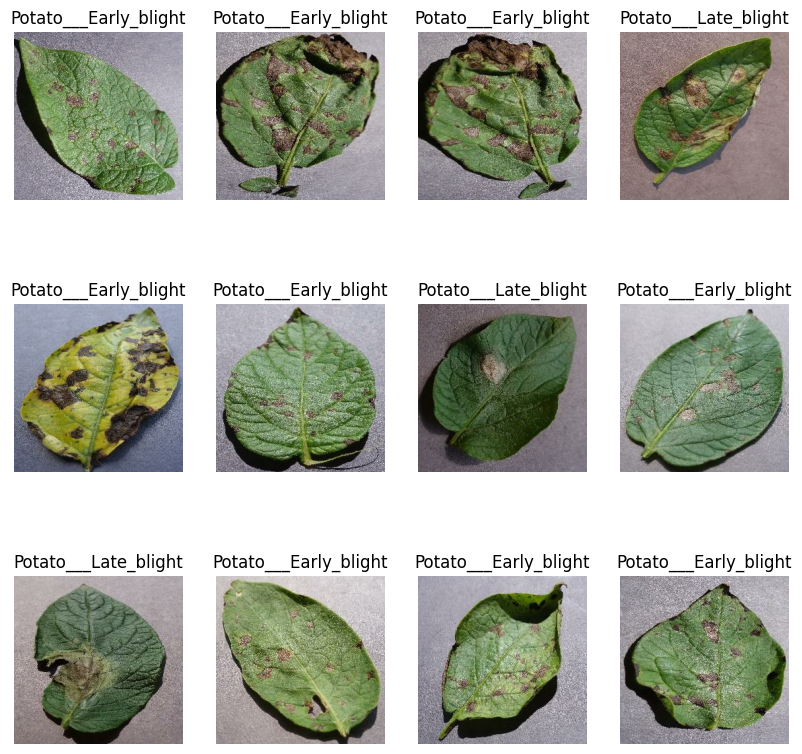

In [11]:

plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [12]:
len(dataset)


68

In [13]:

train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [14]:

train_ds = dataset.take(54)
len(train_ds)

54

In [15]:

test_ds = dataset.skip(54)
len(test_ds)

14

In [16]:

val_size=0.1
len(dataset)*val_size

6.800000000000001

In [17]:

val_ds = test_ds.take(6)
len(val_ds)

6

In [18]:

test_ds = test_ds.skip(6)
len(test_ds)

8

In [19]:

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [20]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [21]:
len(train_ds)


54

In [23]:
len(val_ds)


6

In [24]:
len(test_ds)


8

In [25]:

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [28]:
from tensorflow.keras import layers

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])


In [30]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])


In [31]:

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [36]:

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

In [37]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [38]:

history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 461ms/step - accuracy: 0.5394 - loss: 0.8572 - val_accuracy: 0.5781 - val_loss: 0.9012
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 462ms/step - accuracy: 0.7691 - loss: 0.5248 - val_accuracy: 0.8073 - val_loss: 0.3849
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 26s 471ms/step - accuracy: 0.8692 - loss: 0.3089 - val_accuracy: 0.8021 - val_loss: 0.3685
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 463ms/step - accuracy: 0.8987 - loss: 0.2485 - val_accuracy: 0.9271 - val_loss: 0.2077
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 468ms/step - accuracy: 0.9225 - loss: 0.1961 - val_accuracy: 0.9167 - val_loss: 0.1978
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 489ms/step - accuracy: 0.9358 - loss: 0.1721 - val_accuracy: 0.9479 - val_loss: 0.1429
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 27s 497ms/step - accuracy: 0.9410 - loss: 0.1504 - val_accuracy: 0.9531 - val_loss: 0.1010
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 26s 471ms/step - accuracy: 0.9352 - loss: 0.1822 - val_accu

In [39]:
scores = model.evaluate(test_ds)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.9922 - loss: 0.0490


In [40]:
scores


[0.048954665660858154, 0.9921875]

In [41]:
history


In [42]:
history.params


{'verbose': 1, 'epochs': 50, 'steps': 54}

In [43]:
history.history.keys()


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [44]:
type(history.history['loss'])


list

In [45]:
len(history.history['loss'])


50

In [46]:
history.history['loss'][:5] # show loss for first 5 epochs


[0.8571667671203613,
 0.5248400568962097,
 0.3089306354522705,
 0.2485293298959732,
 0.19608964025974274]

In [47]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

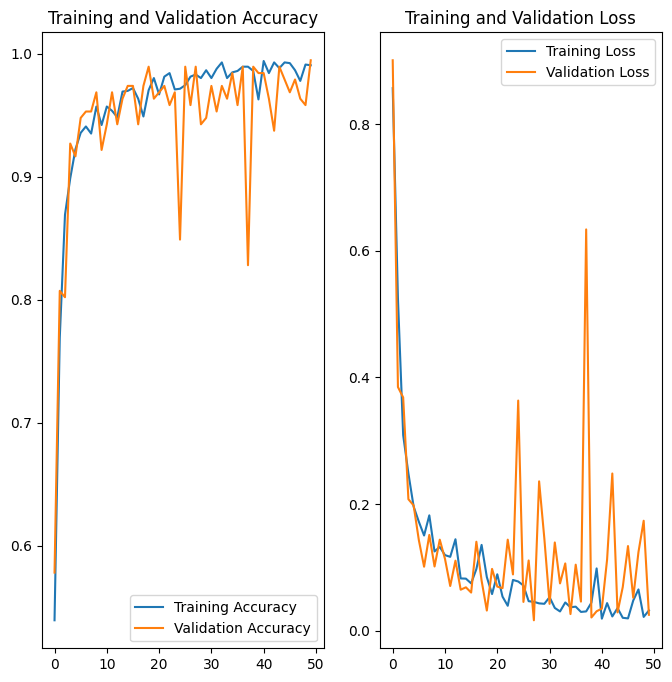

In [48]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
predicted label: Potato___Early_blight


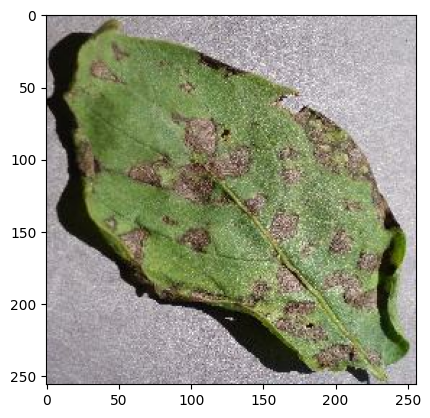

In [49]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [50]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


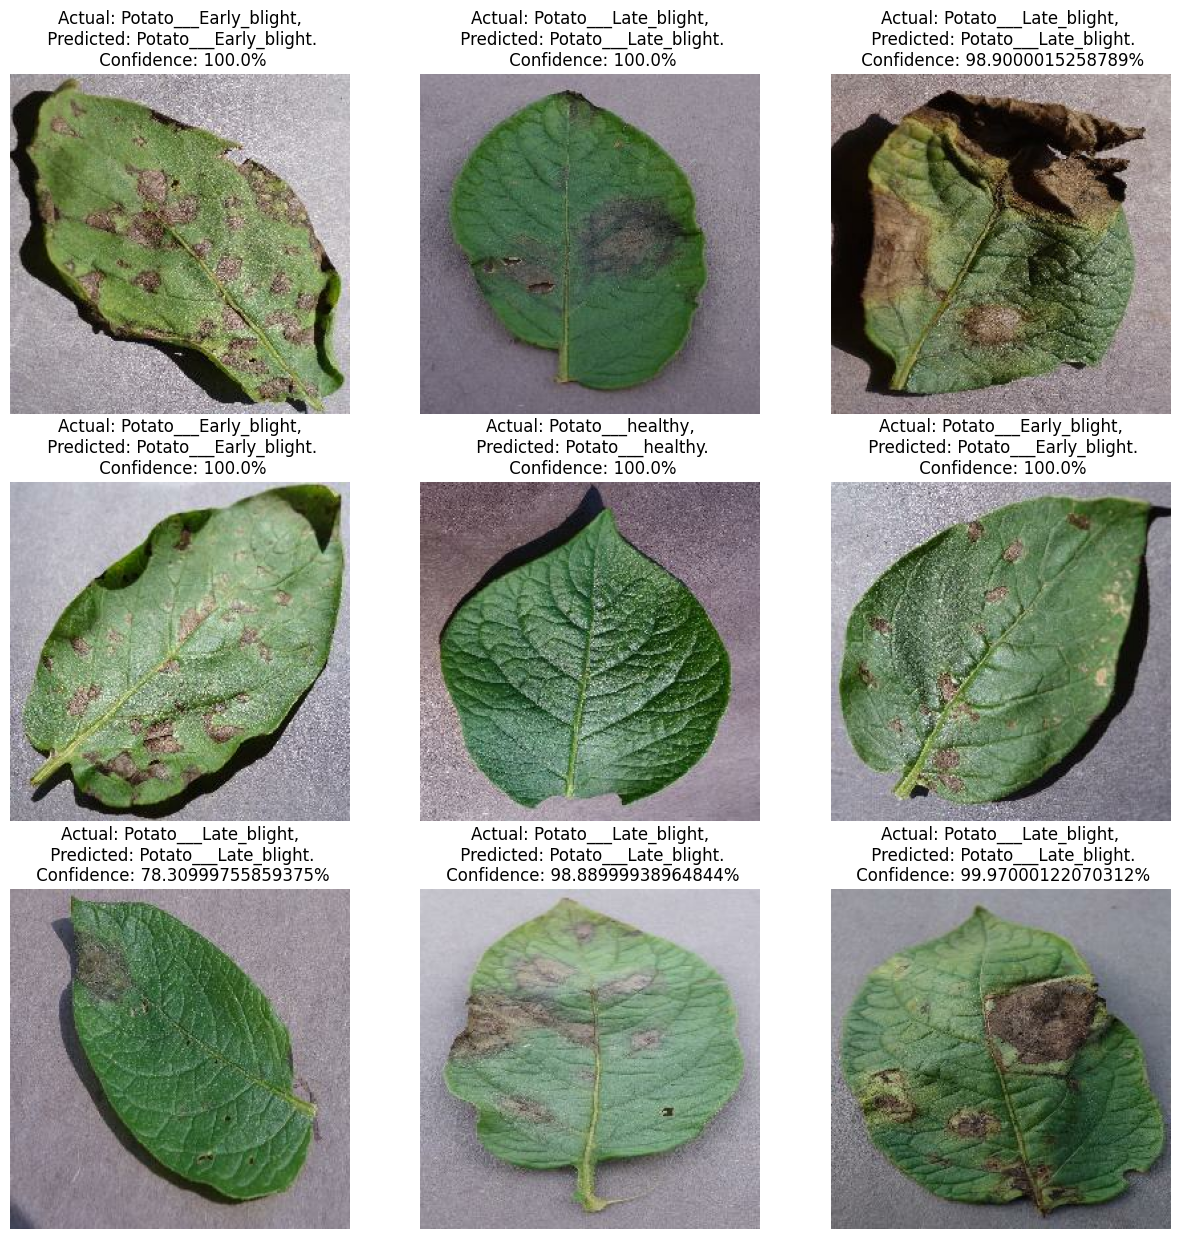

In [51]:

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [58]:
import os

# Folder path
save_dir = r"D:\Crop_image_detection\project\models"

# Agar folder nahi bana hai to bana do
os.makedirs(save_dir, exist_ok=True)

# Model versioning
existing_versions = [
    int(i.split('.')[0]) for i in os.listdir(save_dir) if i.split('.')[0].isdigit()
]
model_version = max(existing_versions, default=0) + 1

# Save model with version number
model_path = os.path.join(save_dir, f"{model_version}.keras")
model.save(model_path)

print(f"✅ Model saved successfully at: {model_path}")


✅ Model saved successfully at: D:\Crop_image_detection\project\models\1.keras


In [59]:
model.save("../potatoes.h5")